# Introduction

# Methodology

# Data and analysis
import required libraries and define constants

In [1]:
import itertools
import collections
import glob
import os
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from lxml import etree

dataset_path = 'dataset'
batch_size = 32
epochs = 40
img_width, img_height = 256, 256
min_sub_image_size = 16

class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']
num_classes = len(class_names)
get_class_name_num = lambda x : {name: i for i, name in enumerate(class_names)}.get(x)

## Helper function to get a section from an image given a bounding box

In [2]:
def crop_to_bounding_box(image, box: '(ymin, ymax, xmin, xmax)', scale=1):
    ymin, ymax, xmin, xmax = box
    h, w = ymax - ymin, xmax - xmin
    x_center, y_center = (xmin + xmax) // 2, (ymin + ymax) // 2
    r = int(scale * (max(h, w) // 2))

    xmin, xmax = x_center - r, x_center + r
    ymin, ymax = y_center - r, y_center + r

    # bounds check
    maxh, maxw = image.shape[:2]
    xmin, ymin = max(0, xmin), max(0, ymin)
    xmax, ymax = min(maxw - 1, xmax), min(maxh - 1, ymax)

    return image[ymin:ymax, xmin:xmax]

## Dataset building and preprocessing
Associate each png image and xml annotation by zipping them. Observe that the paths of each pair of png image and xml annotation are correct.

In [3]:
def get_dataset_paths():
    image_paths = glob.glob(os.path.join(dataset_path, 'images', '*.png'))
    annotation_paths = [image_path.replace('images', 'annotations').replace('.png', '.xml') for image_path in image_paths]
    return zip(image_paths, annotation_paths)

list(get_dataset_paths())[:5]

[('dataset\\images\\maksssksksss0.png',
  'dataset\\annotations\\maksssksksss0.xml'),
 ('dataset\\images\\maksssksksss1.png',
  'dataset\\annotations\\maksssksksss1.xml'),
 ('dataset\\images\\maksssksksss10.png',
  'dataset\\annotations\\maksssksksss10.xml'),
 ('dataset\\images\\maksssksksss100.png',
  'dataset\\annotations\\maksssksksss100.xml'),
 ('dataset\\images\\maksssksksss101.png',
  'dataset\\annotations\\maksssksksss101.xml')]

Define a dataset generator. Each image with its annotation are opened and parsed to produce cropped images of the face as defined in the annotation.

In [4]:
def dataset_generator():
    dataset_paths = get_dataset_paths()

    images, labels = [], []
    for image_path, annotation_path in dataset_paths:
        # read the pair of image and its annotation
        image = cv2.imread(image_path)
        annotation = etree.parse(annotation_path).getroot()

        # for reach object (a face) in the annotation
        for obj in annotation.iterfind('object'):
            # read its label and bounding box
            label = get_class_name_num(obj.find('name').text)
            bounding_box = obj.find('bndbox')

            # get the region of interest from the image
            xmin = int(bounding_box.find('xmin').text)
            xmax = int(bounding_box.find('xmax').text)
            ymin = int(bounding_box.find('ymin').text)
            ymax = int(bounding_box.find('ymax').text)

            image_section = crop_to_bounding_box(image, (ymin, ymax, xmin, xmax), scale=1.5)

            # skip cropped image if too small
            h, w = image_section.shape[:2]
            if min(h, w) < min_sub_image_size: continue

            image_section = tf.image.resize_with_pad(image_section, img_height, img_width)
            yield (image_section, label)

# create a TensorFlow Dataset object from the generator for an optimized input pipeline
dataset = tf.data.Dataset.from_generator(
    dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(img_height, img_width, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).shuffle(1000, seed=16).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Peek at the dataset to check if the dataset is working as expected.

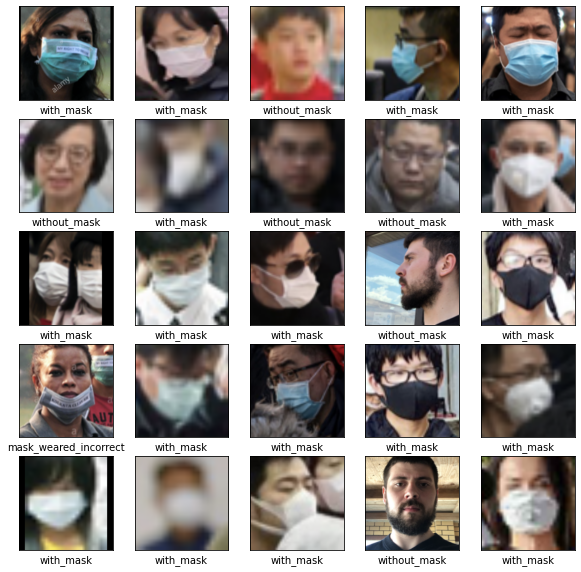

In [5]:
plt.figure(figsize=(10,10))
for i, (image, label) in dataset.enumerate():
    i = i.numpy()
    if i >= 25: break
    image = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(class_names[label])
plt.show()

## Dataset Analysis
The dataset is admittedly unbalanced with an abundance in faces with mask (2882) and a small set for faces with incorrectly worn mask (118). 

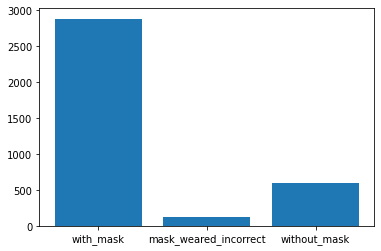

array([2882,  118,  600], dtype=int64)

In [6]:
def plot_dataset_histogram():
    labels = np.fromiter(dataset.map(lambda img, label: label, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).as_numpy_iterator(), dtype='uint8')
    class_name_idx, counts = np.unique(labels, return_counts=True)
    names = np.vectorize(lambda idx: class_names[idx])(class_name_idx)
    plt.bar(names, counts)
    plt.show()
    return counts

plot_dataset_histogram()

Split the dataset into a training set and validation set with a 80:20 split. Test sets are automatically done by the model.
Batch the datasets for quicker model training. Use cache and prefetch for faster data retrieval.

In [7]:
def is_val(x, y):
    return x % 5 == 0

def is_train(x, y):
    return not is_val(x, y)

recover = lambda x, y: y

train_ds = dataset.enumerate().filter(is_train).map(recover)
val_ds = dataset.enumerate().filter(is_val).map(recover)

train_ds = train_ds.batch(batch_size)
train_ds = train_ds.shuffle(1000, seed=47).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.shuffle(1000, seed=47).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Model
Use a combination of convolution, pooling, dropout, and dense layers.

We use the categorical crossentropy because we are categorizing more than two classes (3). We use sparse because the labels are single integers `[0, 1, 2]` instead of being one-hot encoded `[[1, 0, 0], [0, 1, 0], [0, 0, 1]]`.

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)       

## Model fitting

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/40
90/90 [==============================] - 38s 56ms/step - loss: 0.6144 - accuracy: 0.8340 - val_loss: 0.3309 - val_accuracy: 0.9389
Epoch 2/40
90/90 [==============================] - 3s 38ms/step - loss: 0.2710 - accuracy: 0.9184 - val_loss: 0.2758 - val_accuracy: 0.9403
Epoch 3/40
90/90 [==============================] - 3s 38ms/step - loss: 0.2602 - accuracy: 0.9177 - val_loss: 0.2389 - val_accuracy: 0.9417
Epoch 4/40
90/90 [==============================] - 3s 38ms/step - loss: 0.2416 - accuracy: 0.9187 - val_loss: 0.2641 - val_accuracy: 0.9458
Epoch 5/40
90/90 [==============================] - 3s 38ms/step - loss: 0.2280 - accuracy: 0.9260 - val_loss: 0.2219 - val_accuracy: 0.9500
Epoch 6/40
90/90 [==============================] - 4s 39ms/step - loss: 0.2250 - accuracy: 0.9274 - val_loss: 0.1966 - val_accuracy: 0.9486
Epoch 7/40
90/90 [==============================] - 4s 39ms/step - loss: 0.2158 - accuracy: 0.9271 - val_loss: 0.1960 - val_accuracy: 0.9514
Epoch 8/40
9

save model for future use

In [10]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


## Accuracy and loss graphs
Observe that no overfitting nor underfitting is observed. 

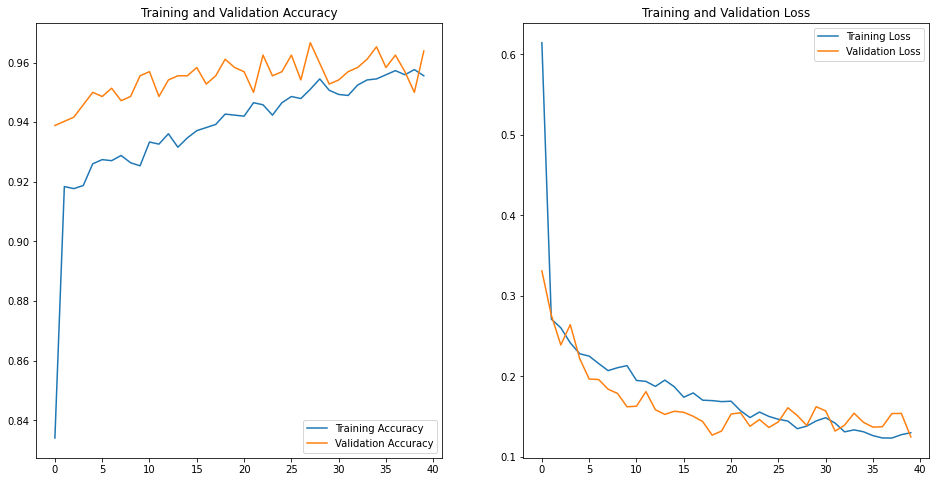

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Confusion matrix
The confusion matrix is decent.

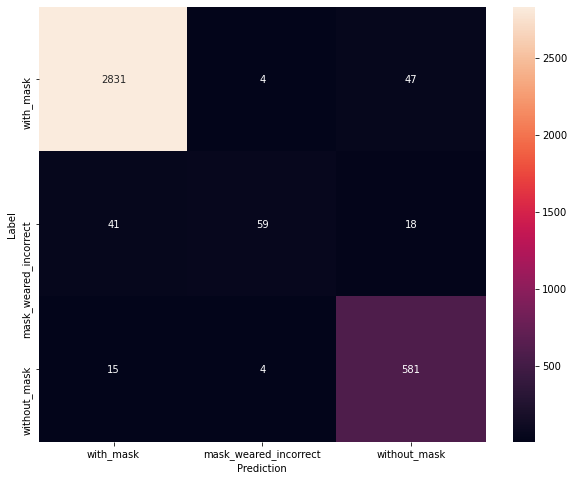

In [12]:
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

y_pred = []
y_true = []

# iterate over the dataset
for image_batch, label_batch in itertools.chain(train_ds, val_ds):
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis=-1))

# convert the true and predicted labels into tensors
labels = tf.concat([item for item in y_true], axis=0)
predictions = tf.concat([item for item in y_pred], axis=0)

cm = tf.math.confusion_matrix(labels, predictions, num_classes=num_classes)

show_confusion_matrix(cm, class_names)

# Conclusion

In [13]:
model = tf.keras.models.load_model('model')

Aleksandr Rybnikov

In [14]:
video = cv2.VideoCapture(0)
video_h, video_w = video.read()[1].shape[:2]
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]

prototxtPath = 'face_detector\\deploy.prototxt'
weightsPath = 'face_detector\\res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

while(True):
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)

    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces_bounds = []

    # loop over the detections
    for i in range(detections.shape[2]):
        # extract confidence
        confidence = detections[0, 0, i, 2]

        # filter out weak detections
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([video_w, video_h, video_w, video_h])
            xmin, ymin, xmax, ymax = box.astype("int")

            xmin, ymin = max(0, xmin), max(0, ymin)
            xmax, ymax = min(video_w - 1, xmax), min(video_h - 1, ymax)

            faces_bounds.append((ymin, ymax, xmin, xmax))

    if len(faces_bounds):
        preds = model.predict(
            np.array([
                tf.image.resize_with_pad(
                    crop_to_bounding_box(frame, bounds, scale=1.4), 
                    img_height,
                    img_width
                ) for bounds in faces_bounds],
                dtype='uint8'
            )
        )

        # for x in [tf.image.resize_with_pad(crop_to_bounding_box(frame, bounds, scale=1.4), img_height, img_width) for bounds in faces_bounds]:
        #     cv2.imshow('image', x.numpy().astype('uint8'))
        #     cv2.waitKey(0)

        # Draw the rectangle around each face
        for (ymin, ymax, xmin, xmax), pred in zip(faces_bounds, preds):
            score = tf.nn.softmax(pred)
            class_name_idx = np.argmax(score)
            class_name, confidence = class_names[class_name_idx], 100 * np.max(score)
            # print(class_name_idx, confidence, class_name)
            
            color = colors[class_name_idx]

            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(frame, f'{class_name} {confidence:.2f}', (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()